In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
%cd Text-to-Face-Generation

/drive/MyDrive/Diffusion/StyleT2I


In [ ]:
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hrls6hc7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hrls6hc7
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 4.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=5d758c4d6a75d5f34163a7d221e50a9221863b918559f9ba37b9d196b6b83536
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehuefl9n/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [24]:
import os
import torch
import torchvision
import random
import numpy as np


from tqdm import tqdm
from model.stylegan2.model import Generator
from dataset.celebahq import CelebAHQ
from torchvision import transforms
from dataset.data_utils import pad_text_seq_collate
from model.text_encoder_cond import Sentence2DeltaLatent

import cv2
import matplotlib.pyplot as plt
import glob

In [ ]:
class Trainer:
    def __init__(self, args):
        self.args = args
        self.device = torch.device(0)

        # model
        self.generator = Generator(args.stylegan_size, 512, 8)
        g_ckpt = torch.load(args.ckpt)["g_ema"]
        self.generator.load_state_dict(g_ckpt, strict=False)
        self.generator.eval()
        self.generator = self.generator.to(self.device)
        for p in self.generator.parameters():
            p.requires_grad = False
        self.synthesis_kwargs = dict(input_is_latent=True, randomize_noise=False)

        if args.truncation < 1:
            self.mean_latent = self.generator.mean_latent(4096)
        else:
            self.mean_latent = None

        if args.latent_space == "w":
            output_dim = args.latent
        elif args.latent_space == "wp":
            output_dim = args.latent * self.generator.n_latent
        else:
            raise NotImplementedError

        self.sentence2latent = Sentence2DeltaLatent(
            args.word_embed_size,
            g_latent_dim=args.latent,
            out_dim=output_dim,
            hidden_dim=args.latent,
            num_mlp_layers=args.text_encoder_num_mlp_layers,
            return_delta=True,
        ).to(self.device)
        self.model_lst = [self.sentence2latent]

        ckpt = torch.load(args.sentence2latent_ckpt)
        self.sentence2latent.load_state_dict(ckpt["sentence_encoder"])

        # dataset
        if args.dataset in ["celebahq", "ffhq"]:
            transform = transforms.Compose(
                [
                    transforms.Resize(args.stylegan_size),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True
                    ),
                ]
            )
            test_split_name = "unseen_test"
            test_set = CelebAHQ(
                "data",
                split=test_split_name,
                transform=transform,
                return_filename=True,
            )
        elif args.dataset in ["cub", "nabirds"]:
            imsize = args.stylegan_size
            test_split_name = "test_unseen"
            transform = transforms.Compose(
                [
                    transforms.Resize(int(imsize * 76 / 64)),
                    transforms.CenterCrop(imsize),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True
                    ),
                ]
            )
            test_set = CUBZeroShotText(
                "data",
                split=test_split_name,
                transform=transform,
                return_filename=True,
            )
        else:
            raise NotImplementedError

        collate_fn = pad_text_seq_collate
        self.test_split_name = test_split_name

        exp_dir_name = args.sentence2latent_ckpt.split("/")[-3]
        exp_dir = os.path.join(args.exp_root, exp_dir_name)
        assert os.path.exists(exp_dir)
        self.vis_dir = os.path.join(exp_dir, "vis", args.name)
        if not os.path.exists(self.vis_dir):
            os.makedirs(self.vis_dir)

        split_dir = os.path.join(self.vis_dir, test_split_name)
        if not os.path.exists(split_dir):
            os.mkdir(split_dir)

        self.test_loader = torch.utils.data.DataLoader(
            test_set,
            args.eval_batch,
            shuffle=False,
            num_workers=args.num_workers,
            pin_memory=False,
            drop_last=False,
            collate_fn=collate_fn,
            persistent_workers=args.num_workers > 0,
        )

    def zero_grad_all(self):
        for o in self.optimizer_lst:
            o.zero_grad()

    def eval_all(self):
        for m in self.model_lst:
            m.eval()

    def false_requires_grad_all(self):
        for m in self.model_lst:
            for p in m.parameters():
                p.requires_grad = False

    def true_requires_grad(self, model_lst):
        for m in model_lst:
            for p in m.parameters():
                p.requires_grad = True

    @torch.no_grad()
    def get_latent(self, noise):
        return self.generator(
            [noise],
            just_latent=True,
            truncation=self.args.truncation,
            truncation_latent=self.mean_latent,
        )[0]

    def forward_sentence2latent(
        self,
        text_embed,
        text_len=None,
        return_delta=False,
        noise=None,
        return_rand_latent=False,
    ):
        if noise is None:
            gaussian_noise = torch.randn(
                text_embed.shape[0], self.args.latent, device=self.device
            )
        else:
            gaussian_noise = noise
        rand_latent = self.get_latent(gaussian_noise)
        latent_code, delta = self.sentence2latent(rand_latent, text_embed, text_len)

        output_lst = [latent_code]

        if return_delta:
            output_lst.append(delta)

        if return_rand_latent:
            output_lst.append(rand_latent)

        if len(output_lst) == 1:
            return output_lst[0]
        else:
            return tuple(output_lst)

    @torch.no_grad()
    def __vis(self, split, loader):
        dir_path = f"{self.vis_dir}/{split}"

        desc = f"visualizing {split} split"
        pbar = tqdm(loader, desc=desc, dynamic_ncols=True)

        for data_dict in pbar:
            text_embed = data_dict["word_embeds"]
            text_len = data_dict["text_len"]
            filename_lst = data_dict["filename"]

            text_embed = text_embed.to(self.device, non_blocking=True)
            gaussian_noise = torch.randn(
                text_embed.shape[0], self.args.latent, device=self.device
            )

            latent_code = self.forward_sentence2latent(
                text_embed, text_len=text_len, noise=gaussian_noise
            )
            fake_img = self.generator([latent_code], **self.synthesis_kwargs)[0]

            for idx_batch in range(fake_img.shape[0]):
                filename = filename_lst[idx_batch]

                if "/" in filename:
                    cur_dir_name = filename.split("/")[0]
                    cur_dir_path = os.path.join(dir_path, cur_dir_name)
                    if not os.path.exists(cur_dir_path):
                        os.mkdir(cur_dir_path)

                img_path = os.path.join(dir_path, filename)
                torchvision.utils.save_image(
                    fake_img[idx_batch : idx_batch + 1],
                    img_path,
                    nrow=1,
                    normalize=True,
                    value_range=(-1, 1),
                    padding=0,
                )

    def visualize(self):
        self.__vis(self.test_split_name, self.test_loader)

In [ ]:
class Args():
    name = None
    dataset = 'celebahq'
    stylegan_size = 256
    eval_batch = 20
    num_workers = 12
    exp_root = 'exp/stylet2i'
    seed = 0
    text_encoder_num_mlp_layers = 2
    ckpt = 'exp/ckpt/stylegan2_celebahq_size_256_split_train/550000.pt'
    sentence2latent_ckpt = 'exp/stylet2i/stylet2i_celebahq_2/ckpt/last.pt'
    truncation = 0.5
    latent_space = 'wp'
    latent = 512
    word_embed_size = 300

args = Args()

In [ ]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [ ]:
if args.name is None:
    args.name = ""

if not os.path.exists(args.exp_root):
    os.mkdir(args.exp_root)

trainer = Trainer(args)
trainer.visualize()

visualizing unseen_test split: 100%|██████████| 98/98 [03:04<00:00,  1.88s/it]


In [ ]:
import pickle

with open('./Text-to-Face-Generation/data/celebahq/novel_composition_caption_unseen_test_cached.pkl', 'rb') as f:
    x = pickle.load(f)

In [ ]:
x[0]

['the woman has wavy hair high cheekbones and bags under eyes and wears earrings ',
 'the person has high cheekbones big lips and brown hair and is wearing earrings ']

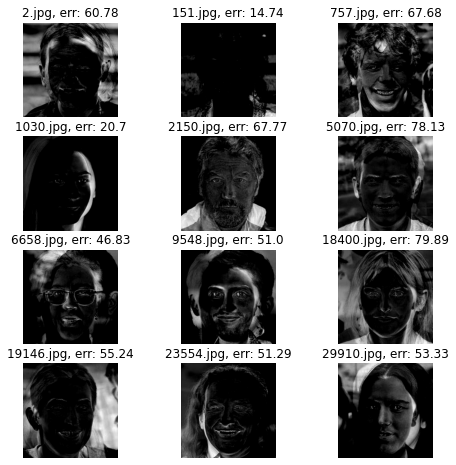

In [ ]:
images_id = [2, 151, 757, 1030, 2150, 5070, 6658, 9548, 18400, 19146, 23554, 29910]
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 4
i = 1
for image_id in images_id:
    image_path1 = 'Text-to-Face-Generation/exp/stylet2i/stylet2i_celebahq/vis/unseen_test/{}.jpg'.format(image_id)
    image_path2 = 'Text-to-Face-Generation/exp/stylet2i/stylet2i_celebahq_2/vis/unseen_test/{}.jpg'.format(image_id)

    img1 = cv2.imread(image_path1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    h, w = img1.shape

    img2 = cv2.imread(image_path2)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    def error(img1, img2):
        diff = cv2.subtract(img1, img2)
        err = np.sum(diff**2)
        mse = err/(float(h*w))
        msre = np.sqrt(mse)
        return mse, diff

    match_error12, diff12 = error(img1, img2)
    match_error12 = round(match_error12, 2)
    title = "{}.jpg, err: {}".format(image_id, match_error12)
    fig.add_subplot(rows, columns, i)
    plt.imshow(diff12,'gray'),plt.title(title),plt.axis('off')
    i += 1
plt.show()

In [57]:
image_path1_pattern = 'Text-to-Face-Generation/exp/stylet2i/stylet2i_celebahq/vis/unseen_test/{}'
image_path2_pattern = 'Text-to-Face-Generation/exp/stylet2i/stylet2i_celebahq_2/vis/unseen_test/{}'
errors = []
i = 0
n = 200
for image_path1 in glob.glob(image_path1_pattern.format('*.jpg')):
    image_name = os.path.basename(image_path1)
    image_path2 = image_path2_pattern.format(image_name)

    img1 = cv2.imread(image_path1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    h, w = img1.shape

    img2 = cv2.imread(image_path2)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    def error(img1, img2):
        diff = cv2.subtract(img1, img2)
        err = np.sum(diff**2)
        mse = err/(float(h*w))
        msre = np.sqrt(mse)
        return mse, diff

    match_error12, diff12 = error(img1, img2)
    match_error12 = round(match_error12, 2)
    errors.append(match_error12)

    i += 1
    if i >= n:
        break
errors = np.array(errors)

In [58]:
print('Error stats:')
print('Length: {}'.format(len(errors)))
print('Min: {}'.format(errors.min()))
print('Max: {}'.format(errors.max()))
print('Mean: {}'.format(errors.mean()))
print('Median: {}'.format(np.median(errors)))

Error stats:
Length: 200
Min: 8.33
Max: 99.9
Mean: 48.81955
Median: 48.445
